In [1]:
from kSZ_forecast_general_func import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [6]:
for i in [0, 25, 39, 49, 21, 29]:
    print(snap_info.zstep[i], snap_info.redshift[i])

5000.0 0.0
2448.0 1.028
1631.0 2.023
1216.0 3.025
2746.0 0.811
2181.0 1.272


In [2]:
# parameters
Grid = 512
redshift_bin = 2
HOD_random_seed = 100
galaxy_number_density_label = 1


the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])

# func

In [35]:
def decompose_along_n_vel(vel, n_los):
    grid = vel.shape[0]
    vel_rec_los = np.sum(vel.reshape(grid, grid, grid, 3)*n_los.reshape(1, 1, 1, 3), axis = 3)
    return vel_rec_los

In [67]:
def cal_r_halo_sample_proj1(vel_rec, halox, halov, halo_mass, the_los, grid):
    halov_los = np.cos(the_los)*halov[:,0]+np.sin(the_los)*halov[:,1]
    r = np.zeros(len(lgM_min))
    sigma_v_rec = np.zeros(len(lgM_min))
    for i in range(len(lgM_min)):
        lgM_min2 = lgM_min[i]
        if i == 0:
            lgM_max2 = 20
        else:
            lgM_max2 = lgM_min[i-1]
        label = np.where((halo_mass<10**lgM_max2)&(halo_mass>10**lgM_min2))[0]
    
        vx = interpn((np.arange(grid),np.arange(grid),np.arange(grid)), vel_rec[:,:,:,0], halox[label]*grid, bounds_error=0, fill_value=0)
        vy = interpn((np.arange(grid),np.arange(grid),np.arange(grid)), vel_rec[:,:,:,1], halox[label]*grid, bounds_error=0, fill_value=0)
        halov_rec_los = np.cos(the_los)*vx+np.sin(the_los)*vy

        
        r[i] = np.mean(halov_rec_los*halov_los[label])/np.std(halov_rec_los)/np.std(halov_los[label])
        sigma_v_rec[i] = np.std(halov_rec_los)
    return r, sigma_v_rec


# galaxy mock sample

In [41]:
if redshift_bin == 0:
    Snapshot = 2448
    lgM_min = np.array([13.21616884, 13.00613391, 12.87405033, 12.6986018 , 12.56470822, 12.47015211, 11.99107016, 11.62894912])
    n_gal = np.array([4, 4.4, 4.8])*10**-4
    HOD_model = "DESI"
    gll = [0,1,2]
    rr = "0.6 < z < 1"
    z_eff = 0.8
if redshift_bin == 1:
    Snapshot = 2448
    lgM_min = np.array([13.21616884, 13.00613391, 12.87405033, 12.6986018 , 12.56470822, 12.47015211, 11.99107016, 11.62894912])
    n_gal = np.array([6, 6.6, 7.2])*10**-4
    HOD_model = "HSC_NB816"
    gll = [0,1,2]
    rr = "1 < z < 1.6"
    z_eff = 1.3
if redshift_bin == 2:
    Snapshot = 1631
    lgM_min = np.array([12.84230083, 12.66537838, 12.54430498, 12.39486591, 12.29210015, 12.2125257 , 11.80201392, 11.48552698])
    n_gal = np.array([3, 3.3, 3.6])*10**-4
    HOD_model = "HSC_NB912"
    gll = [0,1,2]
    rr = "1.6 < z < 2.4"
    z_eff = 2.0

print("Read halos")
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm
haloxx_rsd=add_RSD(halox*Boxlen,halov*(1+z_eff), n_rsd, cosmo.H(z_eff).value)%Boxlen   #Mpc/h

if HOD_model == "DESI":
    richness = np.zeros(len(halo_mass), dtype = np.int32)
    for i in range(4):
        HOD_model_i = "DESI_L"+str(i)
        d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model_i+"_seed"+str(HOD_random_seed)+".npz")
        N_cen = d["N_cen"]
        N_sat = d["N_sat"]
        richness+=(N_cen + N_sat)
else:
    d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
    N_cen = d["N_cen"]
    N_sat = d["N_sat"]
    richness = N_cen + N_sat
N_gal = np.sum(richness)
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
galaxy_pos = np.zeros((N_gal, 3))
galaxy_pos_rsd = np.zeros((N_gal, 3))
for i in range(3):
    galaxy_pos_rsd[:,i]=np.repeat(haloxx_rsd[:,i], richness)
    galaxy_pos[:,i]=np.repeat(halox[:,i], richness)

#rand to make density (for n_gal)
N_gal_need = np.int32(n_gal[galaxy_number_density_label]*Boxlen**3)
a = np.arange(N_gal, dtype=np.int32)
np.random.shuffle(a)
galaxy_pos = galaxy_pos[list(a[:N_gal_need]),:]
galaxy_pos_rsd = galaxy_pos_rsd[list(a[:N_gal_need]),:]
N_gal = len(galaxy_pos[:,0])
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)


Read halos
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 570240    n= 0.00033


In [4]:
print("Read Den/Mom")
MAS = "NGP"
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+z_eff)**2/h  # proj mom: km/h -> dkSZ/CMB
Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)
velp = momden2vel(denp, momp)
momp = (denp-1).reshape(Grid, Grid, Grid,1)*velp
momp_proj=proj1(momp,the_los)*cnorm

Read Den/Mom


In [36]:
velp_los = decompose_along_n_vel(vel=velp, n_los=n_rsd)

# P(k) of density

In [42]:
deng_NGP_rsd = den_NGP(galaxy_pos_rsd,Grid)
deng_NGP = den_NGP(galaxy_pos,Grid)

In [43]:
Pk_deng_rsd, k = fa.CalPS(deng_NGP_rsd, Grid, mapscale=(Boxlen/Grid**2)**3, kscale=2*np.pi/Boxlen)
Pk_deng, k = fa.CalPS(deng_NGP, Grid, mapscale=(Boxlen/Grid**2)**3, kscale=2*np.pi/Boxlen)
Pk_denp, k = fa.CalPS(denp, Grid, mapscale=(Boxlen/Grid**2)**3,kscale=2*np.pi/Boxlen)

(3.3087853069505493, 75240.32917876668)

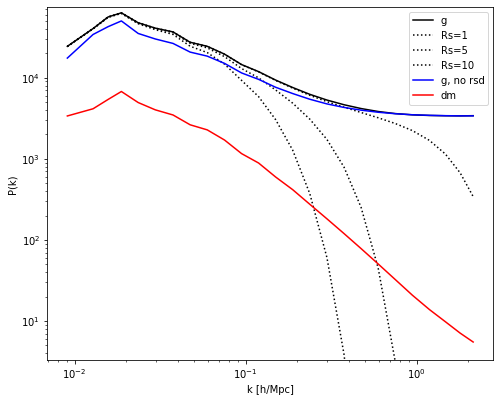

In [46]:
fig, ax = plt.subplots(figsize=(8, 6.5))
Rs=5
plt.plot(k, Pk_deng_rsd, "k",label = "g")
for Rs in [1, 5, 10]:
    plt.plot(k, Pk_deng_rsd*np.exp(-0.5*k**2*Rs**2), ":k", label = "Rs="+str(Rs))
plt.plot(k, Pk_deng, "b", label = "g, no rsd")
plt.plot(k, Pk_denp, "r", label = "dm")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("k [h/Mpc]")
ax.set_ylabel("P(k)")
ax.set_ylim(np.min(Pk_denp)*0.6, np.max(Pk_deng)*1.5)

# reconstruct veloctiy 

## from denp

In [19]:
theta = den2theta(den=denp, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
vel_rec_0 = theta2vel(theta, Boxlen)
label0 = "perfect"
r0, k = fa.CalRvector(vel_rec_0, velp, Grid)

## no rsd, galaxy density

In [47]:
theta = den2theta(den=deng_NGP, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
vel_rec_no_rsd = theta2vel(theta, Boxlen)

## no filter

In [20]:
theta = den2theta(den=deng_NGP_rsd, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
vel_rec_1 = theta2vel(theta, Boxlen)
label1 = "No filter"

## Gaussian filter

In [75]:
vel_rec_g = []

for Rg  in [1, 2, 3,4, 5,6, 7, 10]:
    den_fg = den_filter_g(den=deng_NGP_rsd, Rg=Rg, Boxlen=Boxlen)
    theta = den2theta(den=den_fg, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
    vel_rec_2 = theta2vel(theta, Boxlen)
    vel_rec_g.append(vel_rec_2)


## weiner filter

In [87]:
thetap = vel2theta(velp, Boxlen)
W,kx,ky,kz=wiener_filter_theta_esti(deng_NGP_rsd,thetap, Boxlen)
thetag_rsd_rec=wiener_filter_den2theta(deng_NGP_rsd,W,kx,ky,kz, Boxlen)
vel_rec_w=theta2vel(thetag_rsd_rec, Boxlen)

/home/chenzy/code/kSZ_forecast/kSZ_forecast_general_func.py:222: RuntimeWarning: invalid value encountered in true_divide
  W=cor_the_delta_f[0]/ps_delta[0]


## figures

### r of halos

In [88]:
r_halo_rec_w, sigma_v_rec_w = cal_r_halo_sample_proj1(vel_rec=vel_rec_w, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)

In [76]:
#r_halo_rec_no_rsd, sigma_v_rec_no_rsd = cal_r_halo_sample_proj1(vel_rec=vel_rec_no_rsd, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)
#r_halo_rec_1, sigma_v_rec_1 = cal_r_halo_sample_proj1(vel_rec=vel_rec_1, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)
#r_halo_rec_0, sigma_v_rec_0 = cal_r_halo_sample_proj1(vel_rec=vel_rec_0, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)

r_halo_rec_g = np.zeros((len(lgM_min), len(vel_rec_g)))
sigma_v_rec_g = np.zeros((len(lgM_min), len(vel_rec_g)))
for i in range(len(vel_rec_g)):
    r_halo_rec_g[:,i], sigma_v_rec_g[:,i] = cal_r_halo_sample_proj1(vel_rec=vel_rec_g[i], halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)


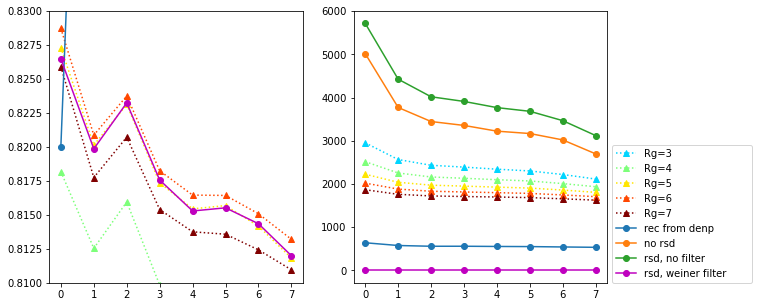

In [92]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=1, vmax=7)
scalarmap=cmx.ScalarMappable(norm=cNorm, cmap=jet)
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

Rg = [1, 2, 3, 4, 5,6, 7, 10]
for i in range(len(vel_rec_g)):
    colorVal = scalarmap.to_rgba(Rg[i])
    if Rg[i]<3 or Rg[i]>8: continue
    ax[0].plot(r_halo_rec_g[:,i], ":^", c = colorVal, label = "Rg="+str(Rg[i]))
    ax[1].plot(sigma_v_rec_g[:,i], ":^", c = colorVal, label="Rg="+str(Rg[i]))
    
ax[0].plot(r_halo_rec_0, "-o", label = "rec from denp")
ax[0].plot(r_halo_rec_no_rsd, "-o", label="no rsd")
ax[0].plot(r_halo_rec_1, "-o", label = "rsd, no filter")
ax[0].plot(r_halo_rec_w, "-o", c="m", label = "rsd, weiner filter")
ax[0].set_ylim(0.81, 0.83)



ax[1].plot(sigma_v_rec_0, "-o", label="rec from denp")
ax[1].plot(sigma_v_rec_no_rsd, "-o", label="no rsd")
ax[1].plot(sigma_v_rec_1, "-o", label="rsd, no filter")
ax[1].plot(sigma_v_rec_w, "-o",  c="m", label = "rsd, weiner filter")
ax[1].legend(bbox_to_anchor=(1.02, 0, 0.55, 1), loc='lower left',ncol=1, mode="expand", borderaxespad=0.)

### r(k)

In [59]:
#vel_rec_los  = decompose_along_n_vel(vel=vel_rec_1, n_los=n_rsd)
#r1, k = fa.CalRvector(vel_rec_1, velp, Grid)
#r1_los, k = fa.CalR(vel_rec_los, velp_los
, Grid)
#r1_cross, k = fa.CalR(vel_rec_1[:,:,:,2], velp[:,:,:,2], Grid)
r1_no_rsd, k = fa.CalR(vel_rec_no_rsd[:,:,:,0], velp[:,:,:,0], Grid)

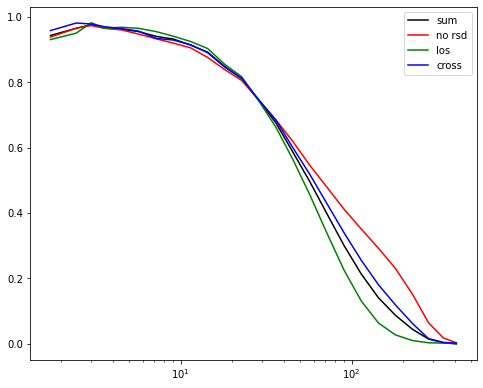

In [61]:
fig, ax = plt.subplots(figsize=(8, 6.5))

ax.plot(k, r1, "k", label = "sum")
ax.plot(k, r1_no_rsd, "r", label = "no rsd")
ax.plot(k, r1_los, "g", label = "los")
ax.plot(k, r1_cross, "b", label = "cross")

ax.legend()
ax.set_xscale("log")
ax.legend()

In [ ]:
vel_rec_loc = vel_rec_1

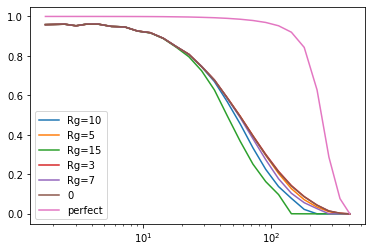

In [54]:

ax.plot(k, r0, label = label0)
ax.legend()
fig

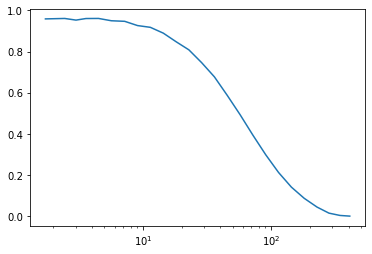

In [34]:
fig, ax = plt.subplots()
ax.plot(k, r1, label = label1)
ax.set_xscale("log")
ax.legend()

In [4]:
from kSZ_forecast_general_func import *

# parameters
Grid = 512
redshift_bin = 0
galaxy_number_density_label = 2
HOD_random_seed = 100


the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])

def decompose_along_n_vel(vel, n_los):
    grid = vel.shape[0]
    vel_rec_los = np.sum(vel.reshape(grid, grid, grid, 3)*n_los.reshape(1, 1, 1, 3), axis = 3)
    return vel_rec_los
def cal_r_halo_sample_proj1(vel_rec, halox, halov, halo_mass, the_los, grid):
    halov_los = np.cos(the_los)*halov[:,0]+np.sin(the_los)*halov[:,1]
    r = np.zeros(len(lgM_min))
    sigma_v_rec = np.zeros(len(lgM_min))
    for i in range(len(lgM_min)):
        lgM_min2 = lgM_min[i]
        if i == 0:
            lgM_max2 = 20
        else:
            lgM_max2 = lgM_min[i-1]
        label = np.where((halo_mass<10**lgM_max2)&(halo_mass>10**lgM_min2))[0]

        vx = interpn((np.arange(grid),np.arange(grid),np.arange(grid)), vel_rec[:,:,:,0], halox[label]*grid, bounds_error=0, fill_value=0)
        vy = interpn((np.arange(grid),np.arange(grid),np.arange(grid)), vel_rec[:,:,:,1], halox[label]*grid, bounds_error=0, fill_value=0)
        halov_rec_los = np.cos(the_los)*vx+np.sin(the_los)*vy


        r[i] = np.mean(halov_rec_los*halov_los[label])/np.std(halov_rec_los)/np.std(halov_los[label])
        sigma_v_rec[i] = np.std(halov_rec_los)
    return r, sigma_v_rec

if redshift_bin == 0:
    Snapshot = 2448
    lgM_min = np.array([13.21616884, 13.00613391, 12.87405033, 12.6986018 , 12.56470822, 12.47015211, 11.99107016, 11.62894912])
    n_gal = np.array([4, 4.4, 4.8])*10**-4
    HOD_model = "DESI"
    gll = [0,1,2]
    rr = "0.6 < z < 1"
    z_eff = 0.8
if redshift_bin == 1:
    Snapshot = 2448
    lgM_min = np.array([13.21616884, 13.00613391, 12.87405033, 12.6986018 , 12.56470822, 12.47015211, 11.99107016, 11.62894912])
    n_gal = np.array([6, 6.6, 7.2])*10**-4
    HOD_model = "HSC_NB816"
    gll = [0,1,2]
    rr = "1 < z < 1.6"
    z_eff = 1.3
if redshift_bin == 2:
    Snapshot = 1631
    lgM_min = np.array([12.84230083, 12.66537838, 12.54430498, 12.39486591, 12.29210015, 12.2125257 , 11.80201392, 11.48552698])
    n_gal = np.array([3, 3.3, 3.6])*10**-4
    HOD_model = "HSC_NB912"
    gll = [0,1,2]
    rr = "1.6 < z < 2.4"
    z_eff = 2.0

print("Read halos")
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm
haloxx_rsd=add_RSD(halox*Boxlen,halov*(1+z_eff), n_rsd, cosmo.H(z_eff).value)%Boxlen   #Mpc/h

if HOD_model == "DESI":
    richness = np.zeros(len(halo_mass), dtype = np.int32)
    for i in range(4):
        HOD_model_i = "DESI_L"+str(i)
        d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model_i+"_seed"+str(HOD_random_seed)+".npz")
        N_cen = d["N_cen"]
        N_sat = d["N_sat"]
        richness+=(N_cen + N_sat)
else:
    d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
    N_cen = d["N_cen"]
    N_sat = d["N_sat"]
    richness = N_cen + N_sat
N_gal = np.sum(richness)
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
galaxy_pos = np.zeros((N_gal, 3))
galaxy_pos_rsd = np.zeros((N_gal, 3))
for i in range(3):
    galaxy_pos_rsd[:,i]=np.repeat(haloxx_rsd[:,i], richness)
    galaxy_pos[:,i]=np.repeat(halox[:,i], richness)

#rand to make density (for n_gal)
N_gal_need = np.int32(n_gal[galaxy_number_density_label]*Boxlen**3)
a = np.arange(N_gal, dtype=np.int32)
np.random.shuffle(a)
galaxy_pos = galaxy_pos[list(a[:N_gal_need]),:]
galaxy_pos_rsd = galaxy_pos_rsd[list(a[:N_gal_need]),:]
N_gal = len(galaxy_pos[:,0])
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)

print("Read Den/Mom")
MAS = "NGP"
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+z_eff)**2/h  # proj mom: km/h -> dkSZ/CMB
Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)
velp = momden2vel(denp, momp)
momp = (denp-1).reshape(Grid, Grid, Grid,1)*velp
momp_proj=proj1(momp,the_los)*cnorm

deng_NGP_rsd = den_NGP(galaxy_pos_rsd,Grid)
deng_NGP = den_NGP(galaxy_pos,Grid)

#from denp
theta = den2theta(den=denp, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
vel_rec_0 = theta2vel(theta, Boxlen)
#no rsd
theta = den2theta(den=deng_NGP, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
vel_rec_no_rsd = theta2vel(theta, Boxlen)
#no filter
theta = den2theta(den=deng_NGP_rsd, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
vel_rec_1 = theta2vel(theta, Boxlen)
#f_g
vel_rec_g = []
Rg  = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30]
for i  in range(len(Rg)):
    den_fg = den_filter_g(den=deng_NGP_rsd, Rg=Rg[i], Boxlen=Boxlen)
    theta = den2theta(den=den_fg, redshift=z_eff, cosmo_model=cosmo, grow_rate_index=4/7.)
    vel_rec_2 = theta2vel(theta, Boxlen)
    vel_rec_g.append(vel_rec_2)
#f_w
thetap = vel2theta(velp, Boxlen)
W,kx,ky,kz=wiener_filter_theta_esti(deng_NGP_rsd,thetap, Boxlen)
thetag_rsd_rec=wiener_filter_den2theta(deng_NGP_rsd,W,kx,ky,kz, Boxlen)
vel_rec_w=theta2vel(thetag_rsd_rec, Boxlen)
r_halo_rec_w, sigma_v_rec_w = cal_r_halo_sample_proj1(vel_rec=vel_rec_w, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)

r_halo_rec_no_rsd, sigma_v_rec_no_rsd = cal_r_halo_sample_proj1(vel_rec=vel_rec_no_rsd, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)
r_halo_rec_1, sigma_v_rec_1 = cal_r_halo_sample_proj1(vel_rec=vel_rec_1, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)
r_halo_rec_0, sigma_v_rec_0 = cal_r_halo_sample_proj1(vel_rec=vel_rec_0, halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)

r_halo_rec_g = np.zeros((len(lgM_min), len(vel_rec_g)))
sigma_v_rec_g = np.zeros((len(lgM_min), len(vel_rec_g)))
for i in tqdm(range(len(vel_rec_g))):
    r_halo_rec_g[:,i], sigma_v_rec_g[:,i] = cal_r_halo_sample_proj1(vel_rec=vel_rec_g[i], halox=halox, halov=halov, halo_mass=halo_mass, the_los=the_los, grid=Grid)

#r(k)
velp_los = decompose_along_n_vel(vel=velp, n_los=n_rsd)
vel_rec_0_los  = decompose_along_n_vel(vel=vel_rec_0, n_los=n_rsd)
vel_rec_1_los  = decompose_along_n_vel(vel=vel_rec_1, n_los=n_rsd)
vel_rec_w_los  = decompose_along_n_vel(vel=vel_rec_w, n_los=n_rsd)
vel_rec_no_rsd_los  = decompose_along_n_vel(vel=vel_rec_no_rsd, n_los=n_rsd)
rk_no_rsd, k = fa.CalR(vel_rec_no_rsd_los, velp_los, Grid)
rk_0, k = fa.CalR(vel_rec_0_los, velp_los, Grid)
rk_1, k = fa.CalR(vel_rec_1_los, velp_los, Grid)
rk_w, k = fa.CalR(vel_rec_w_los, velp_los, Grid)

rk_g = np.zeros((len(k), len(vel_rec_g)))
for i in tqdm(range(len(vel_rec_g))):
	vel_rec_los  = decompose_along_n_vel(vel=vel_rec_g[i], n_los=n_rsd)
	rk_g[:, i], k = fa.CalR(vel_rec_los, velp_los, Grid)

filename="test_rec_method/test_redshiftbin"+str(redshift_bin)+".npy"
np.save(filename, (r_halo_rec_0, sigma_v_rec_0, r_halo_rec_1, sigma_v_rec_1, r_halo_rec_no_rsd, sigma_v_rec_no_rsd, r_halo_rec_g,sigma_v_rec_g, r_halo_rec_w, sigma_v_rec_w, k, rk_g, rk_no_rsd, rk_0, rk_1, rk_w))

Read halos
Number of galaxies 19307693    n= 0.011173433449074075
Number of galaxies 829440    n= 0.00048
Read Den/Mom


/home/chenzy/code/kSZ_forecast/kSZ_forecast_general_func.py:222: RuntimeWarning: invalid value encountered in true_divide
  W=cor_the_delta_f[0]/ps_delta[0]
100%|██████████| 12/12 [05:08<00:00, 25.69s/it]
/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


redshift bin: 1.6 < z < 2.4


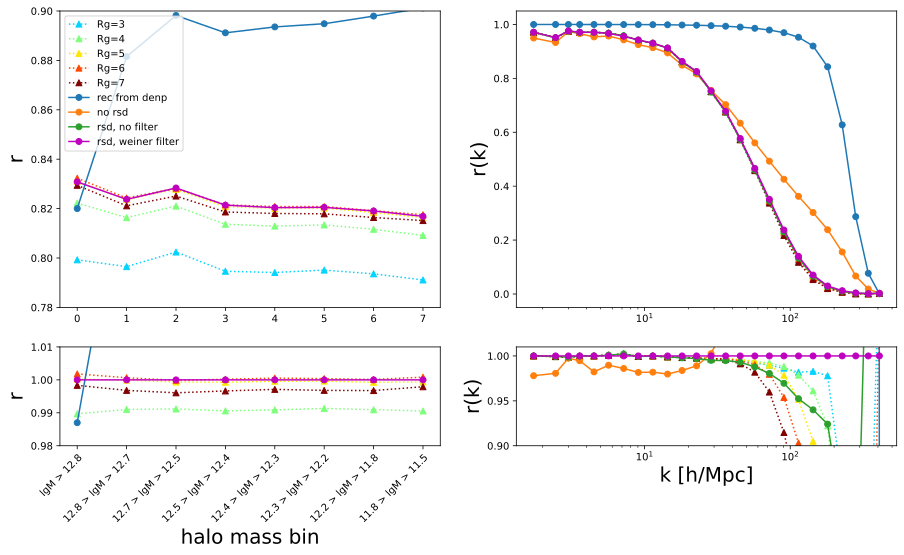

In [67]:
redshift_bin=2
MAS = "NGP"
Grid = 512
filename="test_rec_method/test_redshiftbin"+str(redshift_bin)+".npy"
(r_halo_rec_0, sigma_v_rec_0, r_halo_rec_1, sigma_v_rec_1, r_halo_rec_no_rsd, sigma_v_rec_no_rsd, r_halo_rec_g,sigma_v_rec_g, r_halo_rec_w, sigma_v_rec_w, k, rk_g, rk_no_rsd, rk_0, rk_1, rk_w) =np.load(filename, allow_pickle = True)
#filename="test_rec_method/test_redshiftbin"+str(redshift_bin)+"_"+str(Grid)+"_"+MAS+".npy"
#r_halo_rec_0, sigma_v_rec_0, r_halo_rec_1, sigma_v_rec_1, r_halo_rec_no_rsd, sigma_v_rec_no_rsd, r_halo_rec_g,sigma_v_rec_g, r_halo_rec_w, sigma_v_rec_w, k, rk_g, rk_no_rsd, rk_0, rk_1, rk_w = np.load(filename, allow_pickle=True)

if redshift_bin == 0:
    Snapshot = 2448
    lgM_min = np.array([13.21616884, 13.00613391, 12.87405033, 12.6986018 , 12.56470822, 12.47015211, 11.99107016, 11.62894912])
    n_gal = np.array([4, 4.4, 4.8])*10**-4
    HOD_model = "DESI"
    gll = [0,1,2]
    rr = "0.6 < z < 1"
    z_eff = 0.8
if redshift_bin == 1:
    Snapshot = 2448
    lgM_min = np.array([13.21616884, 13.00613391, 12.87405033, 12.6986018 , 12.56470822, 12.47015211, 11.99107016, 11.62894912])
    n_gal = np.array([6, 6.6, 7.2])*10**-4
    HOD_model = "HSC_NB816"
    gll = [0,1,2]
    rr = "1 < z < 1.6"
    z_eff = 1.3
if redshift_bin == 2:
    Snapshot = 1631
    lgM_min = np.array([12.84230083, 12.66537838, 12.54430498, 12.39486591, 12.29210015, 12.2125257 , 11.80201392, 11.48552698])
    n_gal = np.array([3, 3.3, 3.6])*10**-4
    HOD_model = "HSC_NB912"
    gll = [0,1,2]
    rr = "1.6 < z < 2.4"
    z_eff = 2.0

mass_bin_label = []
for i in range(len(lgM_min)):
    if i == 0:
        mass_bin_label.append("lgM > "+str(np.round(lgM_min[i], 1)))
    else:
        mass_bin_label.append(str(np.round(lgM_min[i-1], 1))+" > lgM > "+ str(np.round(lgM_min[i], 1)))
    

Rg = [1, 2, 3,4, 5,6, 7, 10]

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=1, vmax=7)
scalarmap=cmx.ScalarMappable(norm=cNorm, cmap=jet)
fig, ax = plt.subplots(2, 2, figsize = (15, 8), gridspec_kw={"height_ratios":[3, 1]})

Rg = [1, 2, 3, 4, 5,6, 7, 10]
for i in range(len(Rg)):
    colorVal = scalarmap.to_rgba(Rg[i])
    if Rg[i]<3 or Rg[i]>8: continue
    ax[0, 0].plot(r_halo_rec_g[:,i], ":^", c = colorVal, label = "Rg="+str(Rg[i]))
    ax[0, 1].plot(k, rk_g[:,i], ":^", c = colorVal, label = "Rg="+str(Rg[i]))
    ax[1, 0].plot(r_halo_rec_g[:,i]/r_halo_rec_w, ":^", c = colorVal, label = "Rg="+str(Rg[i]))
    ax[1, 1].plot(k, rk_g[:,i]/rk_w, ":^", c = colorVal, label = "Rg="+str(Rg[i]))
    
    
ax[0, 0].plot(r_halo_rec_0, "-o", label = "rec from denp")
ax[0, 0].plot(r_halo_rec_no_rsd, "-o", label="no rsd")
ax[0, 0].plot(r_halo_rec_1, "-o", label = "rsd, no filter")
ax[0, 0].plot(r_halo_rec_w, "-o", c="m", label = "rsd, weiner filter")
ax[0, 0].set_ylim(0.78, 0.9)
#ax[0, 0].set_xlabel("halo mass bin", fontsize=20)
ax[0, 0].set_ylabel("r", fontsize=20)
ax[0, 0].legend()

ax[1, 0].plot(r_halo_rec_0/r_halo_rec_w, "-o", label = "rec from denp")
ax[1, 0].plot(r_halo_rec_no_rsd/r_halo_rec_w, "-o", label="no rsd")
ax[1, 0].plot(r_halo_rec_1/r_halo_rec_w, "-o", label = "rsd, no filter")
ax[1, 0].plot(r_halo_rec_w/r_halo_rec_w, "-o", c="m", label = "rsd, weiner filter")
ax[1, 0].set_xlabel("halo mass bin", fontsize=20)
ax[1, 0].set_ylabel("r", fontsize=20)
ax[1, 0].set_ylim(0.98, 1.01)


ax[0, 1].plot(k, rk_0, "-o", label = "rec from denp")
ax[0, 1].plot(k, rk_no_rsd, "-o", label="no rsd")
ax[0, 1].plot(k, rk_1, "-o", label = "rsd, no filter")
ax[0, 1].plot(k, rk_w, "-o", c="m", label = "rsd, weiner filter")

ax[0, 1].set_xscale("log")
#ax[0, 1].set_xlabel("k [h/Mpc]", fontsize=20)
ax[0, 1].set_ylabel("r(k)", fontsize=20)

ax[1, 1].plot(k, rk_0/rk_w, "-o", label = "rec from denp")
ax[1, 1].plot(k, rk_no_rsd/rk_w, "-o", label="no rsd")
ax[1, 1].plot(k, rk_1/rk_w, "-o", label = "rsd, no filter")
ax[1, 1].plot(k, rk_w/rk_w, "-o", c="m", label = "rsd, weiner filter")

ax[1, 1].set_xscale("log")
ax[1, 1].set_xlabel("k [h/Mpc]", fontsize=20)
ax[1, 1].set_ylabel("r(k)", fontsize=20)
ax[1, 1].set_ylim(0.9, 1.01)

plt.setp(ax[1, 0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
ax[1, 0].set_xticks(range(len(lgM_min)), labels=mass_bin_label)

print("redshift bin:", rr)

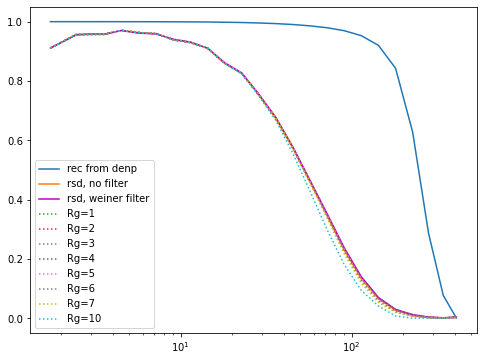

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

ax.plot(k, rk_0, label = "rec from denp")
ax.plot(k, rk_1, label = "rsd, no filter")
ax.plot(k, rk_w, c="m", label = "rsd, weiner filter")
for i in range(len(Rg)):
    ax.plot(k, rk_g[:,i], ":", label="Rg="+str(Rg[i]))
    
ax.legend()
ax.set_xscale("log")